In [1]:
import sys, os
parent_dir = os.getcwd()
path = os.path.dirname(parent_dir)
sys.path.append(path)

from gym_homer.envs.test_env_v0 import HomerEnv
import pandas as pd
import numpy as np

import gym, torch, numpy as np, torch.nn as nn
from tianshou.utils import WandbLogger
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts
from gym import spaces, wrappers

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Load Data
data = pd.read_csv(path+"/test_env_data.csv", index_col=False).fillna(0)
pd.DataFrame(data)

,time_x,time_y,weekend,month_x,month_y,region_1,region_2,region_3,solar,loads,import_tariff,export_tariff,max_d,max_c,soc
0,0.000,1.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
1,0.500,0.866,0,0.0,1.0,0,0,0,-2,0.5,0.05,0.0,0.0,0.0,0.0
2,0.866,0.500,0,0.0,1.0,0,0,0,-2,0.5,0.05,0.0,0.0,0.0,0.0
3,1.000,0.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
4,0.866,-0.500,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
5,0.500,-0.866,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
6,0.000,-1.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
7,-0.500,-0.866,0,0.0,1.0,0,0,0,0,0.5,2.00,2.0,0.0,0.0,0.0
8,-0.866,-0.500,0,0.0,1.0,0,0,0,0,0.5,2.00,2.0,0.0,0.0,0.0
9,-1.000,-0.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0


In [4]:
i = 0

In [22]:
i += 1
#task = 'HomerEnv-v0'
env = HomerEnv(data=data, start_soc='empty')
lr, epoch, batch_size = 1e-4, 20, 128
train_num, test_num = 100, 10
gamma, n_step, target_freq = 1, 10, 20
buffer_size = 20000
eps_train, eps_test = 0.1, 0.05
step_per_epoch, step_per_collect = 1000, len(data)
writer = SummaryWriter('log/dqn')
writer.add_text('id',str(i))
logger = ts.utils.TensorboardLogger(writer)  # TensorBoard is supported!
# For other loggers: https://tianshou.readthedocs.io/en/master/tutorials/logger.html

# you can also try with SubprocVectorEnv
train_envs = ts.env.DummyVectorEnv([lambda: HomerEnv(data=data) for _ in range(train_num)])
test_envs = ts.env.DummyVectorEnv([lambda: HomerEnv(data=data) for _ in range(test_num)])

from tianshou.utils.net.common import Net
# you can define other net by following the API:
# https://tianshou.readthedocs.io/en/master/tutorials/dqn.html#build-the-network
#env = gym.make('gym_homer/HomerEnv-v0', data=data)
wrapped_env = wrappers.FlattenObservation(env)
state_shape = wrapped_env.observation_space.shape or wrapped_env.observation_space.n
action_shape = wrapped_env.action_space.shape or wrapped_env.action_space.n
net = Net(state_shape=state_shape, action_shape=action_shape, hidden_sizes=[64, 64, 32])
optim = torch.optim.Adam(net.parameters(), lr=lr)

policy = ts.policy.DQNPolicy(net, optim, gamma, n_step, target_update_freq=target_freq)
train_collector = ts.data.Collector(policy, train_envs, ts.data.VectorReplayBuffer(buffer_size, train_num), exploration_noise=True)
test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)  # because DQN uses epsilon-greedy method

In [23]:
result = ts.trainer.offpolicy_trainer(
    policy, train_collector, test_collector, epoch, 
    step_per_epoch, step_per_collect,
    test_num, batch_size, update_per_step= 1/step_per_collect,
    train_fn=lambda epoch, env_step: policy.set_eps(eps_train),
    test_fn=lambda epoch, env_step: policy.set_eps(eps_test),
    stop_fn=lambda mean_rewards: mean_rewards >= 4,
    logger=logger)
print(f'Finished training! Use {result["duration"]}')

Epoch #1:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/mbtalexander/Berkeley/w210/home-energy-optimizer/ts/lib/python3.9/site-packages/tianshou/data/collector.py:255: UserWarning: n_step=12 is not a multiple of #env (100), which may cause extra transitions collected into the buffer.
  warnings.warn(
Epoch #1: 1001it [00:00, 3368.70it/s, env_step=1000, len=0, loss=1.301, n/ep=0, n/st=100, rew=0.00]                          


Epoch #1: test_reward: -2.180556 ± 0.016667, best_reward: -2.180556 ± 0.016667 in #0


Epoch #2: 1001it [00:00, 4087.88it/s, env_step=2000, len=11, loss=2.817, n/ep=0, n/st=100, rew=-2.22]                           


Epoch #2: test_reward: 1.569407 ± 1.198229, best_reward: 1.569407 ± 1.198229 in #2


Epoch #3: 1001it [00:00, 4002.10it/s, env_step=3000, len=11, loss=2.482, n/ep=0, n/st=100, rew=1.55]                           


Epoch #3: test_reward: 1.976842 ± 0.007500, best_reward: 1.976842 ± 0.007500 in #3


Epoch #4: 1001it [00:00, 3720.10it/s, env_step=4000, len=11, loss=2.326, n/ep=0, n/st=100, rew=1.52]                           


Epoch #4: test_reward: 1.374473 ± 1.280378, best_reward: 1.976842 ± 0.007500 in #3


Epoch #5: 1001it [00:00, 4097.44it/s, env_step=5000, len=11, loss=2.074, n/ep=0, n/st=100, rew=1.38]                           


Epoch #5: test_reward: 1.564473 ± 1.188736, best_reward: 1.976842 ± 0.007500 in #3


Epoch #6: 1001it [00:00, 3704.27it/s, env_step=6000, len=11, loss=1.891, n/ep=0, n/st=100, rew=1.45]                           


Epoch #6: test_reward: 1.771907 ± 0.591038, best_reward: 1.976842 ± 0.007500 in #3


Epoch #7: 1001it [00:00, 4106.89it/s, env_step=7000, len=11, loss=1.660, n/ep=0, n/st=100, rew=1.51]                           


Epoch #7: test_reward: 1.564605 ± 1.188938, best_reward: 1.976842 ± 0.007500 in #3


Epoch #8: 1001it [00:00, 4133.29it/s, env_step=8000, len=11, loss=1.449, n/ep=0, n/st=100, rew=1.56]                           


Epoch #8: test_reward: 1.776907 ± 0.592625, best_reward: 1.976842 ± 0.007500 in #3


Epoch #9: 1001it [00:00, 4109.32it/s, env_step=9000, len=11, loss=1.398, n/ep=0, n/st=100, rew=1.40]                           


Epoch #9: test_reward: 1.947500 ± 0.017500, best_reward: 1.976842 ± 0.007500 in #3


Epoch #10: 1001it [00:00, 3788.51it/s, env_step=10000, len=11, loss=1.343, n/ep=0, n/st=100, rew=1.58]                          


Epoch #10: test_reward: 1.942500 ± 0.011456, best_reward: 1.976842 ± 0.007500 in #3


Epoch #11: 1001it [00:00, 4092.63it/s, env_step=11000, len=11, loss=1.288, n/ep=100, n/st=100, rew=1.69]                          


Epoch #11: test_reward: 1.939934 ± 0.027757, best_reward: 1.976842 ± 0.007500 in #3


Epoch #12: 1001it [00:00, 4188.27it/s, env_step=12000, len=11, loss=1.254, n/ep=0, n/st=100, rew=1.69]                          


Epoch #12: test_reward: 1.940000 ± 0.022913, best_reward: 1.976842 ± 0.007500 in #3


Epoch #13: 1001it [00:00, 3869.24it/s, env_step=13000, len=11, loss=1.303, n/ep=0, n/st=100, rew=1.31]                           


Epoch #13: test_reward: 1.945000 ± 0.010000, best_reward: 1.976842 ± 0.007500 in #3


Epoch #14: 1001it [00:00, 4056.00it/s, env_step=14000, len=11, loss=1.220, n/ep=0, n/st=100, rew=1.55]                           


Epoch #14: test_reward: 1.532500 ± 0.791521, best_reward: 1.976842 ± 0.007500 in #3


Epoch #15: 1001it [00:00, 4032.31it/s, env_step=15000, len=11, loss=1.173, n/ep=0, n/st=100, rew=1.45]                           


Epoch #15: test_reward: 1.137500 ± 1.606442, best_reward: 1.976842 ± 0.007500 in #3


Epoch #16: 1001it [00:00, 3888.30it/s, env_step=16000, len=11, loss=1.146, n/ep=0, n/st=100, rew=1.54]                           


Epoch #16: test_reward: 1.954868 ± 0.009737, best_reward: 1.976842 ± 0.007500 in #3


Epoch #17: 1001it [00:00, 4160.48it/s, env_step=17000, len=11, loss=1.104, n/ep=0, n/st=100, rew=1.48]                           


Epoch #17: test_reward: 1.937500 ± 0.023049, best_reward: 1.976842 ± 0.007500 in #3


Epoch #18: 1001it [00:00, 4234.88it/s, env_step=18000, len=11, loss=1.149, n/ep=0, n/st=100, rew=1.52]                           


Epoch #18: test_reward: 1.722500 ± 0.599422, best_reward: 1.976842 ± 0.007500 in #3


Epoch #19: 1001it [00:00, 4041.07it/s, env_step=19000, len=11, loss=1.132, n/ep=0, n/st=100, rew=1.51]                           


Epoch #19: test_reward: 1.505000 ± 0.790316, best_reward: 1.976842 ± 0.007500 in #3


Epoch #20: 1001it [00:00, 4215.04it/s, env_step=20000, len=11, loss=1.103, n/ep=0, n/st=100, rew=1.46]                           

Epoch #20: test_reward: 1.905000 ± 0.015000, best_reward: 1.976842 ± 0.007500 in #3
Finished training! Use 5.26s


In [24]:
result

{'duration': '5.26s',
 'train_time/model': '4.28s',
 'test_step': 2310,
 'test_episode': 210,
 'test_time': '0.16s',
 'test_speed': '14561.59 step/s',
 'best_reward': 1.9768416484934277,
 'best_result': '1.98 ± 0.01',
 'train_step': 20000,
 'train_episode': 1800,
 'train_time/collector': '0.82s',
 'train_speed': '3918.38 step/s'}

In [8]:
torch.save(policy.state_dict(), 'dqn.pth')

/Users/mbtalexander/Berkeley/w210/home-energy-optimizer/ts/lib/python3.9/site-packages/tianshou/data/collector.py:68: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


{'n/ep': 1,
 'n/st': 11,
 'rews': array([-0.45000006]),
 'lens': array([11]),
 'idxs': array([0]),
 'rew': -0.4500000551342964,
 'len': 11.0,
 'rew_std': 0.0,
 'len_std': 0.0}

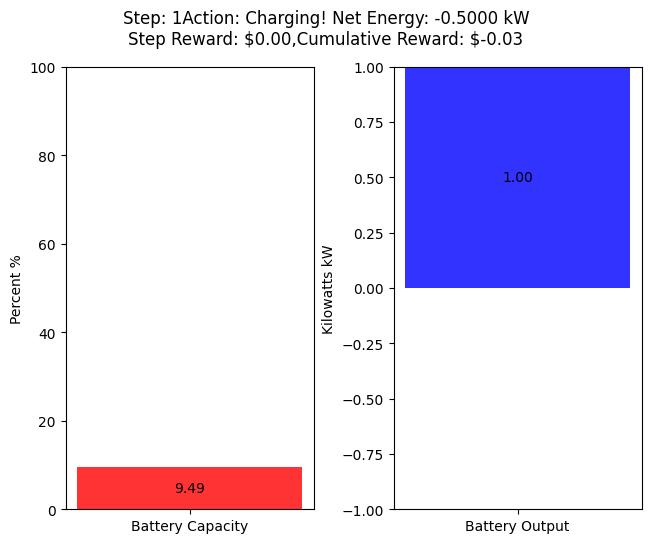

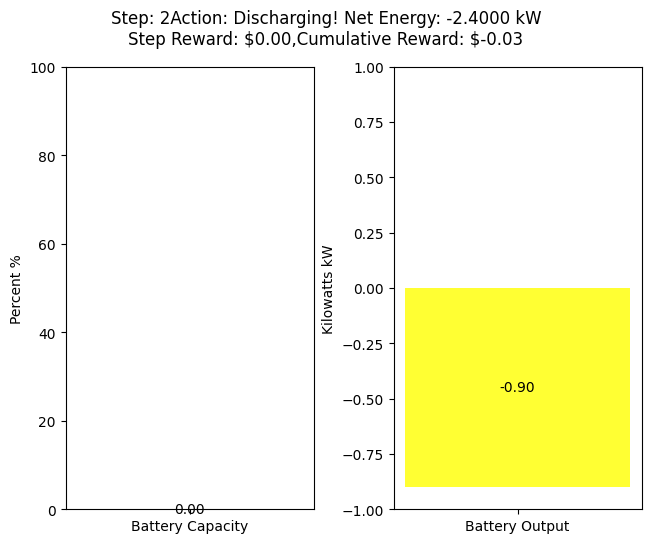

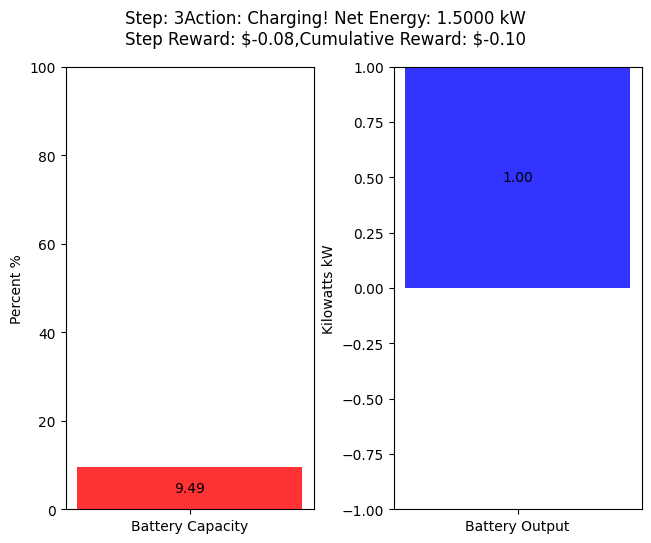

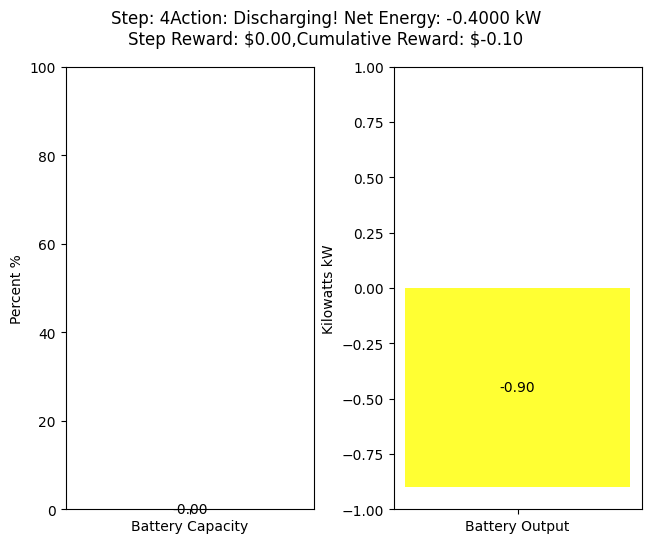

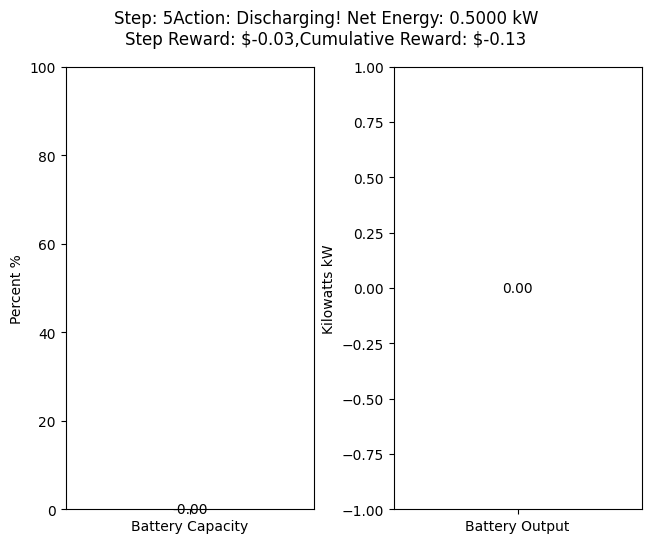

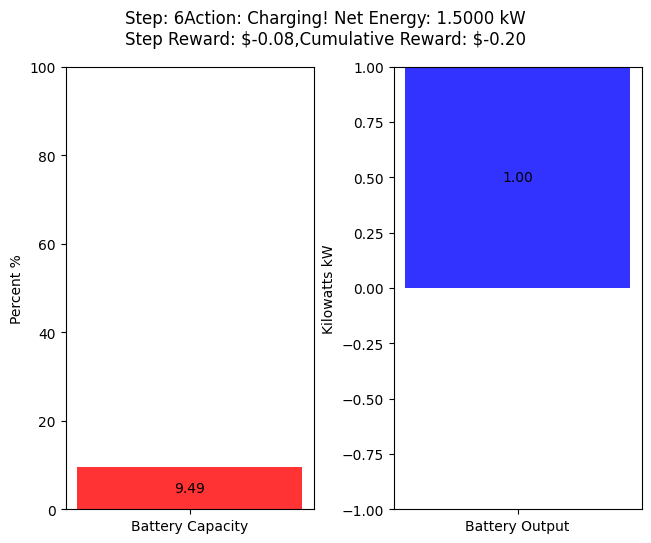

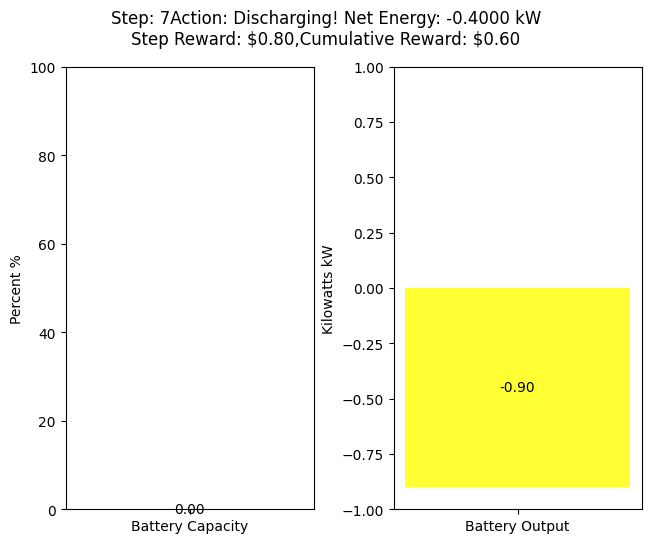

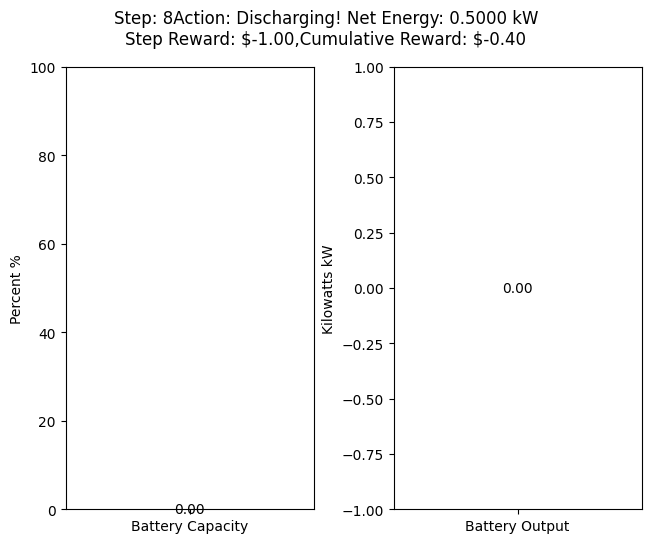

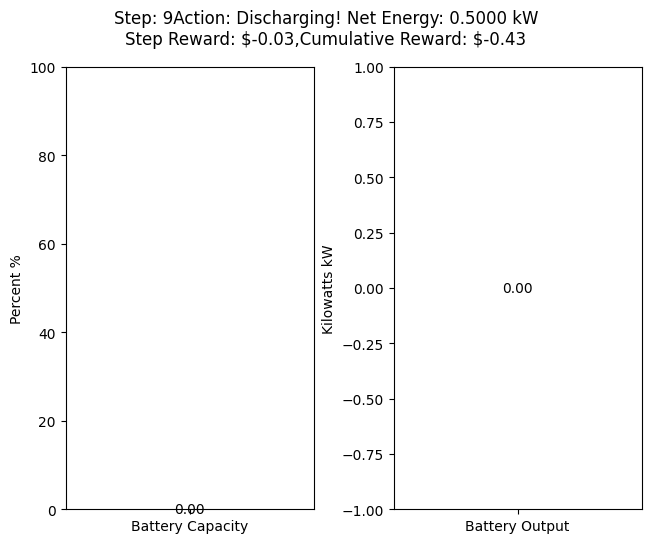

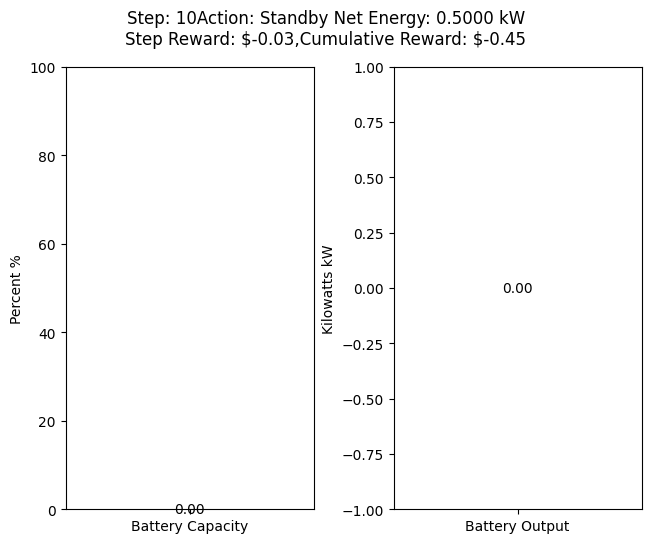

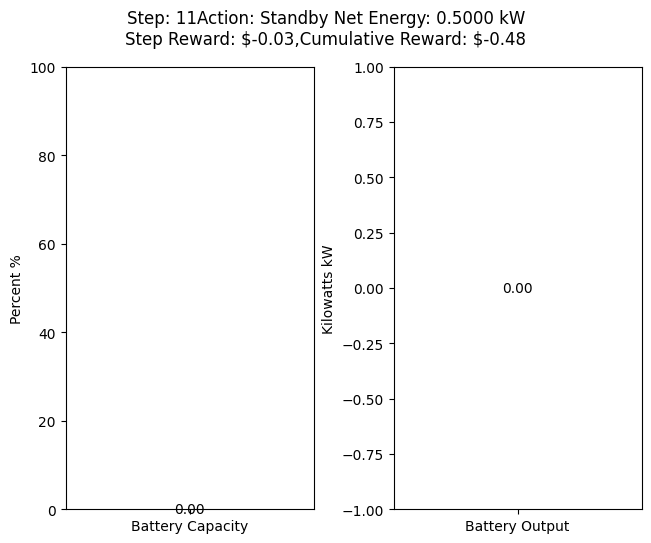

In [41]:
policy.load_state_dict(torch.load('dqn.pth'))
policy.eval()
policy.set_eps(0.4)
collector = ts.data.Collector(policy, env, exploration_noise=True)
collector.collect(n_episode=1, render=True)

In [39]:
print(result)

{'duration': '5.26s', 'train_time/model': '4.28s', 'test_step': 2310, 'test_episode': 210, 'test_time': '0.16s', 'test_speed': '14561.59 step/s', 'best_reward': 1.9768416484934277, 'best_result': '1.98 ± 0.01', 'train_step': 20000, 'train_episode': 1800, 'train_time/collector': '0.82s', 'train_speed': '3918.38 step/s'}


In [49]:
# Load files from render
import imageio
png_dir = (os.getcwd()+"/renders/empty/")

images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

/var/folders/2y/h6n3cj4s35305t1bly9_g0740000gp/T/ipykernel_3664/3926967957.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


In [50]:
# make a gif
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave(png_dir+"/empty_movie.gif", images, fps=1)

/var/folders/2y/h6n3cj4s35305t1bly9_g0740000gp/T/ipykernel_3664/1873241265.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
